In [0]:
from colabtools import bigquery
from colabtools import publish, magicfunc
bigquery.USE_LEGACY_SQL = False
project_id = 'FILL IN' #@param
client_Name = 'FILL IN' #@param
impression_Table = "FILL IN" #@param
activity_Table = "FILL IN" #@param
campaign_IDs = "('1', '2')" #@param
activity_IDs = "('1','2')" #@param
start_Date = "'YYYY-MM-DD'" #@param
end_Date = "'YYYY-MM-DD'" #@param
time_Lag = '30' #@param
converters_Impression_Start_Date = "'YYYY-MM-DD'" #@param
user_Test = "'FILL IN'" #@param

# Prep

In [2]:
bigquery.Create(project_id=project_id)
import seaborn as sns


********************************************************************
** New OAuth2 credentials needed, beginning authorization process **
********************************************************************


Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/v2/auth?redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&client_id=977385342095.apps.googleusercontent.com&response_type=code&access_type=offline&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth



/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_pool_default_33.kernel.colaboratory-playground.44394005975.14b334fb3717c109/mount/server/notebook.par/google3/third_party/py/oauth2client_4_0/_helpers.py:255: UserWarning: Cannot access /dev/null: No such file or directory


Authentication successful.

************************************************
** Continuing execution of BigQuery operation **
************************************************



# Perform Checks

In [3]:
%%substitute_globals
%%bigquery Check

SELECT
Count (*) as Impressions,
SUM (Case when User_ID = '0' THEN 1 ELSE 0 END) AS User_ID0,
SUM (Active_View_Eligible_Impressions) AS Eligible_Impressions,
SUM (Active_View_Measurable_Impressions) AS Measurable_Impressions,
SUM (Active_View_Viewable_Impressions) AS Viewable_Impressions
FROM {impression_Table}
WHERE Campaign_ID IN {campaign_IDs}
AND CAST(DATE(TIMESTAMP_MICROS(CAST(Event_Time as INT64)),"America/New_York") AS STRING) BETWEEN {start_Date} AND {end_Date}

Waiting on bqjob_r2d632619f53a2471_00000167f63c4edf_1 ... (23s) Current status: DONE   


Saving results into 'Check'


In [4]:
Check['User_ID0_Percent'] = Check['User_ID0']/Check['Impressions']
Check['Eligible_Percent'] = Check['Eligible_Impressions']/Check['Impressions']
Check['Measurable_Percent'] = Check['Measurable_Impressions']/Check['Eligible_Impressions']
Check['Viewable_Percent'] = Check['Viewable_Impressions']/Check['Measurable_Impressions']
Check

,Impressions,User_ID0,Eligible_Impressions,Measurable_Impressions,Viewable_Impressions,User_ID0_Percent,Eligible_Percent,Measurable_Percent,Viewable_Percent
0,232569263,29718890,128493628,102853934,65371582,0.127785,0.552496,0.800459,0.635577


# Analysis

## All User Data

In [5]:
%%substitute_globals
%%bigquery Frequency
max_rows: 100000

# Build total frequency curve with measurable and viewable data
WITH
# Step 1: Get info and user level
impressions AS (
  SELECT
    User_ID,
    SUM (Active_View_Measurable_Impressions) AS Measurable_Frequency,
    SUM (Active_View_Viewable_Impressions) AS Viewable_Frequency
  FROM {impression_Table}
  WHERE Campaign_ID IN {campaign_IDs}
  AND User_ID != '0'
  AND CAST(DATE(TIMESTAMP_MICROS(CAST(Event_Time as INT64)),"America/New_York") AS STRING) BETWEEN {start_Date} AND {end_Date}
  GROUP BY 1 
)
# Step 2: Aggregate #1 to build total curve
  SELECT
    Measurable_Frequency,
    Viewable_Frequency,
    COUNT (User_ID) AS Unique_Cookies
  FROM impressions
  WHERE Measurable_Frequency > 0
  AND Viewable_Frequency <= Measurable_Frequency
  GROUP BY 1,2
  ORDER BY 1,2

Waiting on bqjob_r73f97c9bf8282969_00000167f63cb517_2 ... (22s) Current status: DONE   


Saving results into 'Frequency'


## Converter Only Data

In [6]:
%%substitute_globals
%%bigquery Converters
max_rows: 100000

# Build same frequency curve but for converters only
WITH
# Step 1: Get all converters - only count the first (or Last) conversion
conversions AS (
    SELECT
      User_ID,
      MAX (Event_Time) AS Activity_Time # Count the Last Conversion
      #MIN (Event_Time) AS Activity_Time # Count the First Conversion
    FROM {activity_Table}
    WHERE User_ID != '0'
    #AND User_ID = {user_Test} -- use only for QA/testing
    AND Activity_ID IN {activity_IDs}
    AND CAST(DATE(TIMESTAMP_MICROS(CAST(Event_Time as INT64)),"America/New_York") AS STRING) BETWEEN {start_Date} AND {end_Date}
    GROUP BY 1
),
# Step 2: Selects all impressions at user level
impressions AS(
  SELECT
    User_ID,
    Event_Time AS Interaction_Time,
    Active_View_Eligible_Impressions AS Eligible_Impressions,
    Active_View_Measurable_Impressions AS Measurable_Impressions,
    Active_View_Viewable_Impressions AS Viewable_Impressions
  FROM {impression_Table}
  WHERE User_ID != "0"
  #AND User_ID = {user_Test} -- use only for QA/testing
  AND Campaign_ID IN {campaign_IDs}
  AND CAST(DATE(TIMESTAMP_MICROS(CAST(Event_Time as INT64)),"America/New_York") AS STRING) BETWEEN {converters_Impression_Start_Date} AND {end_Date}
),
# Step 3: Joins step 1 and 2 together. Removes any impression occuring after the conversion
full_path AS (
  SELECT *
  FROM impressions
  INNER JOIN conversions USING (User_ID)
  WHERE (Activity_Time - Interaction_Time) > 0
),
# Step 4: Remove any impressions outside of the attribution window
full_path_lookback AS (
  SELECT *,
    (Activity_Time - Interaction_Time) / (1e6*60*60*24) AS Time_Lag_Days
  FROM full_path
  WHERE ((Activity_Time - Interaction_Time) / (1e6*60*60*24)) <= {time_Lag}
),
# Step 5: Aggregate step 4. Gets the measurable and viewable frequency count at the user level for converters only
full_path_aggregated AS (
  SELECT
    User_ID,
    SUM (Measurable_Impressions) AS Measurable_Frequency,
    SUM (Viewable_Impressions) AS Viewable_Frequency
  FROM full_path_lookback
  GROUP BY 1
)
# Step 6: Gives us final frequency curve for converters only
  SELECT
    Measurable_Frequency,
    Viewable_Frequency,
    COUNT (User_ID) AS Unique_Converters
  FROM full_path_aggregated
  WHERE Measurable_Frequency > 0
  AND Viewable_Frequency <= Measurable_Frequency
  GROUP BY 1,2
  ORDER BY 1,2

Waiting on bqjob_r53c77ad11926d117_00000167f63d20e2_3 ... (34s) Current status: DONE   


Saving results into 'Converters'


# Prep Output

In [0]:
# Step 1: Build masks for converters at each measurable frequency bucket
MaskCF1 = Converters[Converters['Measurable_Frequency'] == 1]
MaskCF2 = Converters[Converters['Measurable_Frequency'] == 2]
MaskCF3 = Converters[Converters['Measurable_Frequency'] == 3]
MaskCF4 = Converters[Converters['Measurable_Frequency'] == 4]
MaskCF5 = Converters[Converters['Measurable_Frequency'] == 5]
MaskCF6 = Converters[Converters['Measurable_Frequency'] == 6]

# Step 2: Build masks for all users at each measurable frequency bucket
MaskTF1 = Frequency[Frequency['Measurable_Frequency'] == 1]
MaskTF2 = Frequency[Frequency['Measurable_Frequency'] == 2]
MaskTF3 = Frequency[Frequency['Measurable_Frequency'] == 3]
MaskTF4 = Frequency[Frequency['Measurable_Frequency'] == 4]
MaskTF5 = Frequency[Frequency['Measurable_Frequency'] == 5]
MaskTF6 = Frequency[Frequency['Measurable_Frequency'] == 6]

# Step 3: Join masks together
Join1 = MaskTF1.merge(MaskCF1, left_on = 'Viewable_Frequency', right_on = 'Viewable_Frequency', how = 'left').drop('Measurable_Frequency_y', axis =1).rename(columns = {'Measurable_Frequency_x': 'Measurable_Frequency'})
Join2 = MaskTF2.merge(MaskCF2, left_on = 'Viewable_Frequency', right_on = 'Viewable_Frequency', how = 'left').drop('Measurable_Frequency_y', axis =1).rename(columns = {'Measurable_Frequency_x': 'Measurable_Frequency'})
Join3 = MaskTF3.merge(MaskCF3, left_on = 'Viewable_Frequency', right_on = 'Viewable_Frequency', how = 'left').drop('Measurable_Frequency_y', axis =1).rename(columns = {'Measurable_Frequency_x': 'Measurable_Frequency'})
Join4 = MaskTF4.merge(MaskCF4, left_on = 'Viewable_Frequency', right_on = 'Viewable_Frequency', how = 'left').drop('Measurable_Frequency_y', axis =1).rename(columns = {'Measurable_Frequency_x': 'Measurable_Frequency'})
Join5 = MaskTF5.merge(MaskCF5, left_on = 'Viewable_Frequency', right_on = 'Viewable_Frequency', how = 'left').drop('Measurable_Frequency_y', axis =1).rename(columns = {'Measurable_Frequency_x': 'Measurable_Frequency'})
Join6 = MaskTF6.merge(MaskCF6, left_on = 'Viewable_Frequency', right_on = 'Viewable_Frequency', how = 'left').drop('Measurable_Frequency_y', axis =1).rename(columns = {'Measurable_Frequency_x': 'Measurable_Frequency'})

# Step 4: Add conversion rate to each data frame
Join1['ConversionRate'] = Join1['Unique_Converters'] / Join1['Unique_Cookies']
Join2['ConversionRate'] = Join2['Unique_Converters'] / Join2['Unique_Cookies']
Join3['ConversionRate'] = Join3['Unique_Converters'] / Join3['Unique_Cookies']
Join4['ConversionRate'] = Join4['Unique_Converters'] / Join4['Unique_Cookies']
Join5['ConversionRate'] = Join5['Unique_Converters'] / Join5['Unique_Cookies']
Join6['ConversionRate'] = Join6['Unique_Converters'] / Join6['Unique_Cookies']

In [0]:
# Step 1: Build base case conversion rate
MaskCVF = Converters[Converters['Viewable_Frequency'] == 0]
MaskTVF = Frequency[Frequency['Viewable_Frequency'] == 0]
JoinVF0 = MaskCVF.merge(MaskTVF, left_on = 'Measurable_Frequency', right_on = 'Measurable_Frequency', how = 'left').drop('Viewable_Frequency_y', axis =1).rename(columns = {'Viewable_Frequency_x': 'Viewable_Frequency'})
JoinVF0['ConversionRate'] = JoinVF0['Unique_Converters'] / JoinVF0['Unique_Cookies']
JoinVF0 = JoinVF0[0:6]

# Output

## Measurable Frequency Distribution

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_pool_default_33.kernel.colaboratory-playground.44394005975.14b334fb3717c109/mount/server/notebook.par/google3/third_party/py/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.


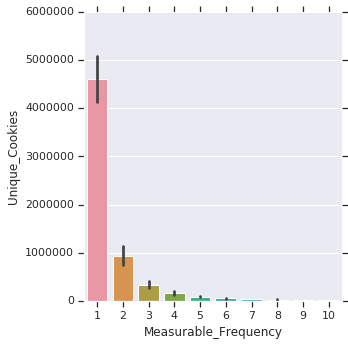

In [9]:
sns.set_palette("muted",n_colors=7)
MaskMF = Frequency[Frequency['Measurable_Frequency'] <= 10]
sns.factorplot(x='Measurable_Frequency', y='Unique_Cookies', data=MaskMF, kind = 'bar')

## Base Case

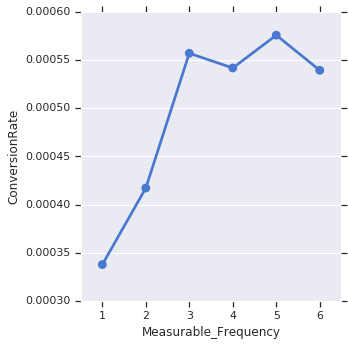

In [10]:
sns.factorplot(x='Measurable_Frequency', y='ConversionRate', data=JoinVF0, kind = 'point')

## Lift for each Measurable Frequency Bucket

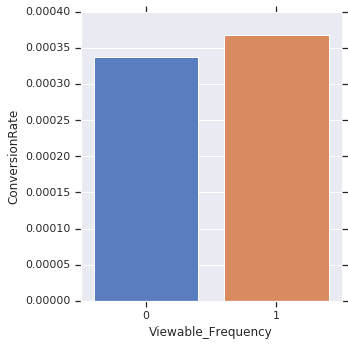

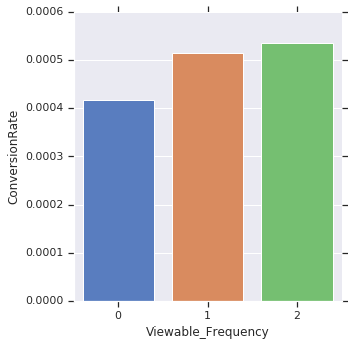

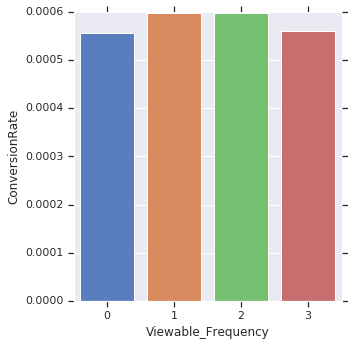

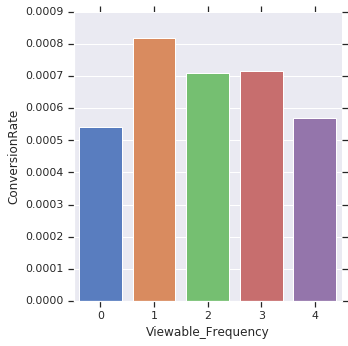

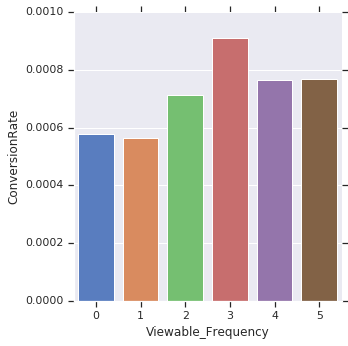

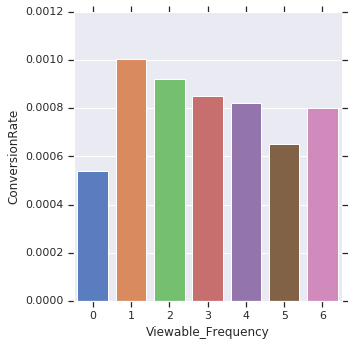

In [11]:
sns.factorplot(x='Viewable_Frequency', y='ConversionRate', data=Join1, kind = 'bar')
sns.factorplot(x='Viewable_Frequency', y='ConversionRate', data=Join2, kind = 'bar')
sns.factorplot(x='Viewable_Frequency', y='ConversionRate', data=Join3, kind = 'bar')
sns.factorplot(x='Viewable_Frequency', y='ConversionRate', data=Join4, kind = 'bar')
sns.factorplot(x='Viewable_Frequency', y='ConversionRate', data=Join5, kind = 'bar')
sns.factorplot(x='Viewable_Frequency', y='ConversionRate', data=Join6, kind = 'bar')

## Aggregated Lift Number (All Viewable paths compared to Non-Viewable paths)

In [12]:
Non_Viewable_Converters = Converters.loc[Converters['Viewable_Frequency']==0,'Unique_Converters'].sum() #Total users that convert but see no viewable ads
Viewable_Converters = Converters.loc[Converters['Viewable_Frequency']>0,'Unique_Converters'].sum() #Total users that convert and do see viewable ads
Non_Viewable_Users = Frequency.loc[Frequency['Viewable_Frequency']==0,'Unique_Cookies'].sum() #Total users that see no viewable ads
Viewable_Users = Frequency.loc[Frequency['Viewable_Frequency']>0,'Unique_Cookies'].sum() #Total users that see viewable ads
Non_Viewable_CR = (Non_Viewable_Converters / float(Non_Viewable_Users))
Viewable_CR = (Viewable_Converters / float(Viewable_Users))
Incremental_Rate = (Viewable_CR - Non_Viewable_CR) / (Viewable_CR)
Output = {"Viewable CR": round(Viewable_CR,4), "Non_Viewable CR": round(Non_Viewable_CR,4), "Incremental": round(Incremental_Rate,3)}
Output

{'Incremental': 0.38, 'Non_Viewable CR': 0.0004, 'Viewable CR': 0.0006}

# Use to get raw data in sheets

In [0]:
from colabtools import sheets
sheet_id = sheets.create_spreadsheet('Incremental'+str({client_Name})) #build new workbook
dataconverter = sheets.add_worksheet(sheet_id, 'Converters')
dataall = sheets.add_worksheet(sheet_id, 'AllUsers')

Beginning OAuth2 authorization process ...
Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fspreadsheets&client_id=26410270374-qledtqqegfh47hg82l580jjr5kv0r6rm.apps.googleusercontent.com&response_type=code&access_type=offline

Authentication successful.


In [0]:
%%substitute_globals
%%html
<a target="_blank" href="https://docs.google.com/spreadsheets/d/{sheet_id}/edit">
Use this sheet!
</a>

In [0]:
sheets.update_cells(sheet_id, dataconverter, Converters,1,1,True, True)
sheets.update_cells(sheet_id, dataall, Frequency,1,1,True, True)

4199 cells updated.
172839 cells updated.
